In [1]:
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import json

In [2]:
# KIBA dataset loading

path = 'C:\\Users\\user\\Desktop\\DTI\\Database'

affinity = pd.read_csv(path + '/KIBA/affinity.txt', header=None, sep = '\t')
affinity = affinity.fillna(-1)

with open(path + '/KIBA/target_seq.txt') as f:
    target = json.load(f)

with open(path + '/KIBA/SMILES.txt') as f:
    drug = json.load(f)

target = list(target.values())
drug = list(drug.values())

In [3]:
binary = False
convert_to_log = False
threshold = 30

In [4]:
# target / target_edit

SMILES = []
Target_seq = []
y = []

for i in range(len(drug)):
    for j in range(len(target)): # target / target_edit 수정
        if affinity.values[i, j] != -1:
            SMILES.append(drug[i])
            Target_seq.append(target[j]) # target / target_edit 수정
            y.append(affinity.values[i, j])
            
if binary:
		print('Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter')
		y = [1 if i else 0 for i in np.array(y) < threshold]
else:
	if convert_to_log:
		print('Default set to logspace (nM -> p) for easier regression')
		y = dataset.convert_y_unit(np.array(y), 'nM', 'p')
	else:
		y = y
   
X_drugs, X_targets, y = np.array(SMILES), np.array(Target_seq), np.array(y)

In [5]:
#### data_process ####

drug_encoding, target_encoding = 'CNN', 'CNN'

In [6]:
# data_process : parameter

X_drug = X_drugs
X_target = X_targets
y=y
drug_encoding='CNN'
target_encoding='CNN'
split_method = 'random'
frac = [0.7, 0.1, 0.2]
random_seed = 1
sample_frac = 1
mode = 'DTI'
X_drug_ = None
X_target_ = None

In [7]:
# data_process : dataframe

if random_seed == 'TDC':
	random_seed = 1234
 
#property_prediction_flag = X_target is None
property_prediction_flag, function_prediction_flag, DDI_flag, PPI_flag, DTI_flag = False, False, False, False, False

if (X_drug is not None) and (X_target is not None):
	DTI_flag = True
	if (X_drug is None) or (X_target is None):
		raise AttributeError("Target pair sequence should be in X_target, X_drug")
else:
	raise AttributeError("Please use the correct mode. Currently, we support DTI, DDI, PPI, Drug Property Prediction and Protein Function Prediction...")

if split_method == 'repurposing_VS':
	y = [-1]*len(X_drug) # create temp y for compatitibility

if DTI_flag:
	print('Drug Target Interaction Prediction Mode...')
	if isinstance(X_target, str):
		X_target = [X_target]
	if len(X_target) == 1:
		# one target high throughput screening setting
		X_target = np.tile(X_target, (length_func(X_drug), ))

	df_data = pd.DataFrame(zip(X_drug, X_target, y))
	df_data.rename(columns={0:'SMILES',
							1: 'Target Sequence',
							2: 'Label'}, 
							inplace=True)
	print('in total: ' + str(len(df_data)) + ' drug-target pairs')
 
 # data_process : endcoding & splitting
if sample_frac != 1:
	df_data = df_data.sample(frac = sample_frac) #.reset_index(drop = True)
	print('after subsample: ' + str(len(df_data)) + ' data points...') 

if DTI_flag:
	df_data = utils.encode_drug(df_data, drug_encoding)
	df_data = utils.encode_protein(df_data, target_encoding)

Drug Target Interaction Prediction Mode...
in total: 118254 drug-target pairs
encoding drug...
unique drugs: 2068
encoding protein...
unique target sequence: 229


In [8]:
# after pre-processing set 불러오기
after_train = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\KIBA\\KIBA_edit_train.tsv', sep='\t', index_col=0)
after_val = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\KIBA\\KIBA_edit_val.tsv', sep='\t', index_col=0)
after_test = pd.read_csv('C:\\Users\\user\\Desktop\\DTI\\Database\\KIBA\\KIBA_edit_test.tsv', sep='\t', index_col=0)

In [15]:
# 같은 index를 가지게 split / index 초기화
train = df_data.loc[after_train.index, :]
val = df_data.loc[after_val.index, :]
test = df_data.loc[after_test.index, :]
train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

In [16]:
# Model configuration genreration
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 100, 
                         test_every_X_epoch = 10, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         cnn_drug_filters = [32,64,96],
                         cnn_drug_kernels = [4,6,8],
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )


In [21]:
# Model initialization
model = models.model_initialize(**config)
model

Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 139.575. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.70101. Total time 0.01 hours
Training at Epoch 1 iteration 200 with loss 0.91352. Total time 0.01972 hours
Training at Epoch 1 iteration 300 with loss 1.12666. Total time 0.02972 hours
Training at Epoch 1 iteration 400 with loss 0.67855. Total time 0.03944 hours
Training at Epoch 1 iteration 500 with loss 0.81236. Total time 0.04916 hours
Training at Epoch 1 iteration 600 with loss 0.67051. Total time 0.05888 hours
Validation at Epoch 1 with loss:0.27720, MSE: 0.68108 , Pearson Correlation: 0.51710 with p-value: 0.00E+00 , Concordance Index: 0.70532
Training at Epoch 2 iteration 0 with loss 0.75812. Total time 0.07166 hours
Training at Epoch 2 iteration 100 with loss 0.66641. Total time 0.08166 hours
Training at Epoch 2 iteration 200 with loss 0.87131. Total time 0.09138 hours
Training at Epoch 2 iteratio

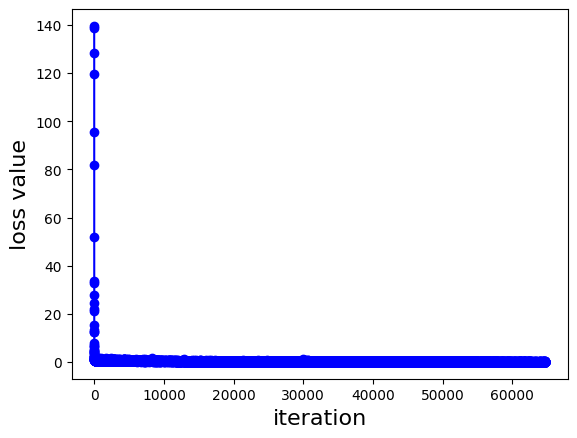

In [22]:
# Model training
model.train(train, val, test)

# Model saving
model.save_model('./pretrained_model/CNN_CNN_KIBA_before/')